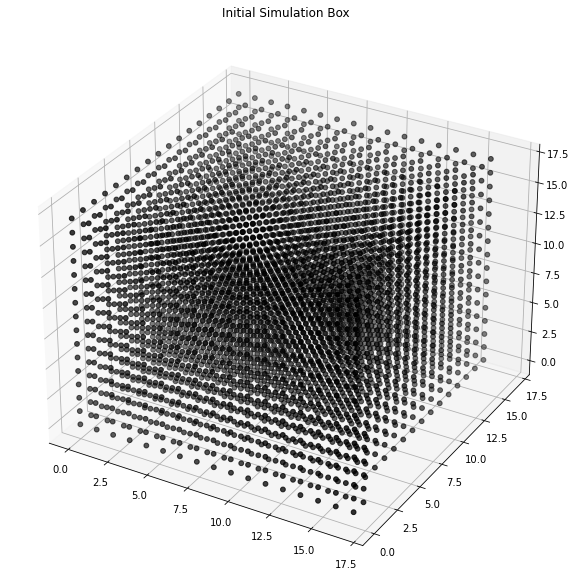

In [4]:
import numpy as np
import random
import math
import matplotlib.pyplot as plt
np.random.seed(0)  # Seed for reproducibility

L = 18.0
rho = 0.75
T = 1
Peos = 0.9891
N = int((L**3) * rho)

pold = np.zeros((N, 3))
# initial locations
nop = 0
for x in range(17):
    for y in range(17):
        for z in range(16):
            if nop < N:
                pold[nop] = np.array([x * 1.05, y * 1.05, z * 1.125])
                nop += 1


# Plotting the simulation box
fig = plt.figure(figsize=(10,15))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(pold[:, 0], pold[:, 1], pold[:, 2], s=23, c='black')
ax.set_title('Initial Simulation Box')
plt.show()

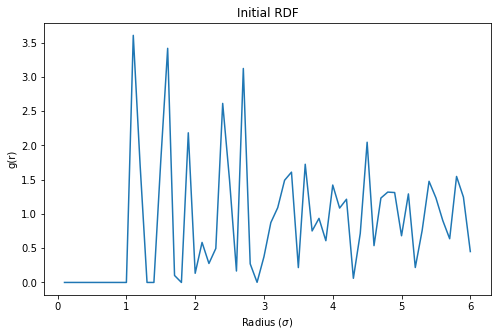

In [5]:
# Compute differences
delta_xyz = pold[:, None, :] - pold[None, :, :]
delta_xyz -= L * np.round(delta_xyz / L)
rx = delta_xyz[:, :, 0]
ry = delta_xyz[:, :, 1]
rz = delta_xyz[:, :, 2]

# Compute distances
r = np.sqrt(rx**2 + ry**2 + rz**2)

# initial RDF calculation
dr = 0.1
Radius = np.arange(0.1, 6.1, 0.1)
grinit = np.zeros(60)
for i in range(1, 61):
    mask = np.logical_and(r <= i * dr, r > (i - 1) * dr)
    sp = np.sum(np.triu(mask, k=1))
    grinit[i - 1] = sp * 3 * L ** 3 / (2 * np.pi * N * (N - 1) * ((i * dr) ** 3 - ((i - 1) * dr) ** 3))
        
# Plotting RDF
plt.figure(figsize=(8,5))
plt.plot(Radius, grinit)
plt.title('Initial RDF')
plt.xlabel('Radius ($\sigma$)')
plt.ylabel('g(r)')
plt.show()

In [6]:
Ushift = 4 * (1 / 2.5 ** 12 - 1 / 2.5 ** 6)
# Computing the potential energy of each atom
fltr = np.logical_and((r <= 2.5),(r > 0))
oldU = np.sum((4 * ((1 / ((r * fltr) ** 12 + 1 * (~fltr))) - 1 / ((r * fltr) ** 6 + 1 * (~fltr))) - (Ushift * fltr) ), axis=1)
# OR - Computing the potential energy of each atom
# oldU = np.zeros(N)
# for i in range(N):
#     for j in range(N):
#         if r[i,j] <= 2.5 and i != j:
#             oldU[i] += ((4 * (1 / r[i,j] ** 12 - 1 / r[i,j] ** 6)) - Ushift)

# Compute potential energy incrementally
uini = np.sum(oldU)/2
# print('uini = ', uini)
# OR - Compute potential energy incrementally
# fltr = np.logical_and((r <= 2.5),(r > 0))
# unew = np.sum(2 * ((1 / r[fltr] ** 12) - 1 / r[fltr] ** 6))  - np.sum(fltr) * Ushift/2
# print('unew = ', unew)
# mask = np.logical_and((r <= 2.5),(r>0))
# uini = np.sum(2 * ((1 / r[mask] ** 12) - 1 / r[mask] ** 6 - (1 / 2.5 ** 12) + 1 / 2.5 ** 6))
# print('unew = ', uini)

# MonteCarlo NPT
am = 0
rm = 0
av = 0
rv = 0
mcstep = 0
rdfps = 0
volume = L**3
rho = N / volume
rhot = [rho]
Ut = [uini]
nts = 1500000
mxd = 0.1
mxdl = 0.1
step = 0
gr = np.zeros(60)
# Main loop
while (step < nts):
    step += 1
    if step % 50 > 0:
        # Choose 1 particle randomly
        sa = math.floor(random.random() * N)
        # Move the atom randomly
        temp = pold[sa] + (np.random.uniform(0,1, size=3) - 0.5) * mxd    
        # Apply periodic boundary conditions
        temp = np.where(temp > L, temp - L, temp)
        temp = np.where(temp < 0, temp + L, temp)
        Ui = 0
        # Calculate the distance between the chosen particle with other particles at previous coordination
        # Compute the old energy of the chosen particle
        # Calculate the distance between the chosen particle with other particles
        rnew = pold - temp
        rnew [sa] = 0
        # Periodic boundary condition
        rnew -= L * np.round(rnew / L)
        rnew = np.sqrt(np.sum(rnew ** 2, axis=1))
        fltr = np.logical_and((rnew <= 2.5),(rnew > 0))
        Ui = np.sum(4 * ((1 / rnew[fltr] ** 12) - (1 / rnew[fltr] ** 6) )) - np.sum(fltr) * Ushift
        


        # for j in range(N):
                
        # #     # Calculate the distance between the chosen particle with other particles
        # #     rinew = pold[j] - temp
        # #     # Periodic boundary condition
        # #     rinew -= L * np.round(rinew / L)
        # #     rnew = np.sqrt(np.sum(rinew**2))
        # #     # Compute the new energy of the chosen particle
        #     if rnew[j] < 2.5 and sa != j:
        #         Ui += 4 * ((1 / rnew[j]**12) - 1 / rnew[j]**6 - (1 / 2.5**12) + 1 / 2.5**6)
        # print (Ui)
        dU = Ui - oldU[sa]

        # Acceptance condition
        if (dU / T) < 70:
            if dU <= 0 or random.random() < math.exp(-dU / T):
                am += 1
                mcstep += 1
                pold[sa] = temp
                uini += dU
                oldU[sa] = Ui
                volume = L**3
                rho = N / volume
                rhot.append(rho)
                Ut.append(uini)

                # Calculate RDF
                if ((mcstep % 10 == 0) and (mcstep > 900000)):
                    rdfps += 1
                    for i in range(1, 61):
                        mask = np.logical_and(r <= i * dr, r > (i - 1) * dr)
                        sp = np.sum(np.triu(mask, k=1))
                        gr[i - 1] += sp * 3 * L ** 3 / (2 * np.pi * N * (N - 1) * ((i * dr) ** 3 - ((i - 1) * dr) ** 3))

            else:
                rm += 1
        else:
            rm += 1

    else:
        # Volume change
        newl = L + (np.random.uniform(0,1) - 0.5) * mxdl

        vold = L ** 3
        vnew = newl ** 3
        newp = pold * (newl / L)
        # Compute differences
        delta_xyz = newp[:, None, :] - newp[None, :, :]
        delta_xyz -= newl * np.round(delta_xyz / newl)
        rx = delta_xyz[:, :, 0]
        ry = delta_xyz[:, :, 1]
        rz = delta_xyz[:, :, 2]
        # Compute distances
        rnew = np.sqrt(rx**2 + ry**2 + rz**2)
        # Set all diagonal elements to zero
        np.fill_diagonal(rnew, 0)

        fltr = np.logical_and((rnew <= 2.5),(rnew > 0))
        unew = np.sum(2 * ((1 / rnew[fltr] ** 12) - 1 / rnew[fltr] ** 6) - Ushift/2)
        # print (unew)

        acc = -(1 / T) * ((unew - uini) + Peos * (vnew - vold) - (N + 1) * T * np.log(vnew / vold))

        if random.random() < np.exp(acc):
            mcstep += 1
            av += 1
            L = newl
            pold = newp.copy()

            oldU = np.sum((4 * ((1 / ((rnew * fltr) ** 12 + 1 * (~fltr))) - 1 / ((rnew * fltr) ** 6 + 1 * (~fltr))) - (Ushift * fltr) ), axis=1)
            # oldU = np.zeros(N)
            # for i in range(N):
            #     for j in range(N):
            #         if r[i,j] <= 2.5 and i != j:
            #             oldU[i] += ((4 * (1 / r[i,j] ** 12 - 1 / r[i,j] ** 6)) - Ushift)

            # Compute potential energy incrementally
            uini = np.sum(oldU)/2
            volume = L**3
            rho = N / volume
            rhot.append(rho)
            Ut.append(uini)
            # Calculate RDF
            if ((mcstep % 10 == 0) and (mcstep > 900000)):
                rdfps += 1
                for i in range(1, 61):
                    mask = np.logical_and(r <= i * dr, r > (i - 1) * dr)
                    sp = np.sum(np.triu(mask, k=1))
                    gr[i - 1] += sp * 3 * L ** 3 / (2 * np.pi * N * (N - 1) * ((i * dr) ** 3 - ((i - 1) * dr) ** 3))
        else:
            rv += 1


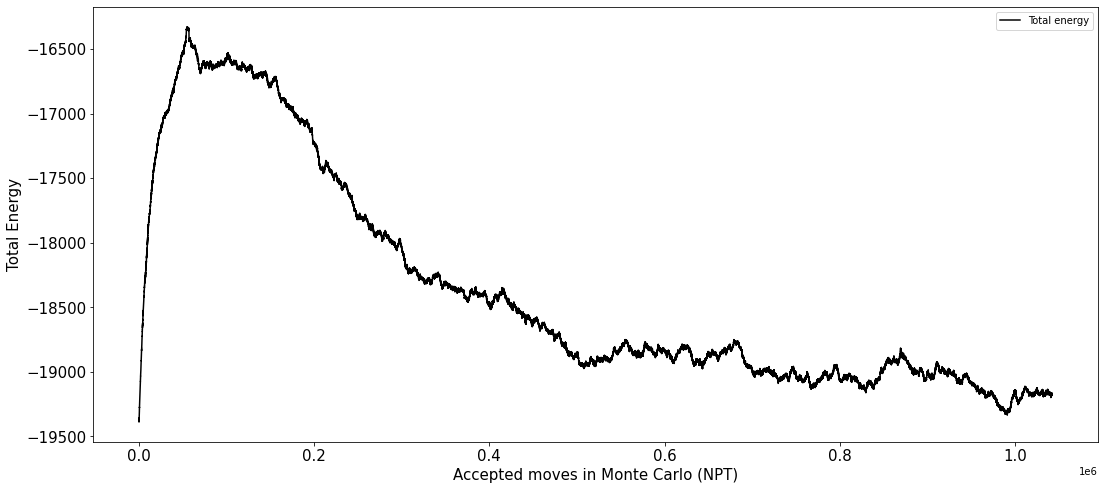

In [7]:
plt.figure(figsize=(18,8))
plt.plot(range(len(Ut)), Ut, color='black', label='Total energy')
plt.xlabel('Accepted moves in Monte Carlo (NPT)', fontsize=15)
plt.ylabel('Total Energy',fontsize=15)
plt.xticks(fontsize=15)
plt.legend()
plt.yticks(fontsize=15)

plt.show()

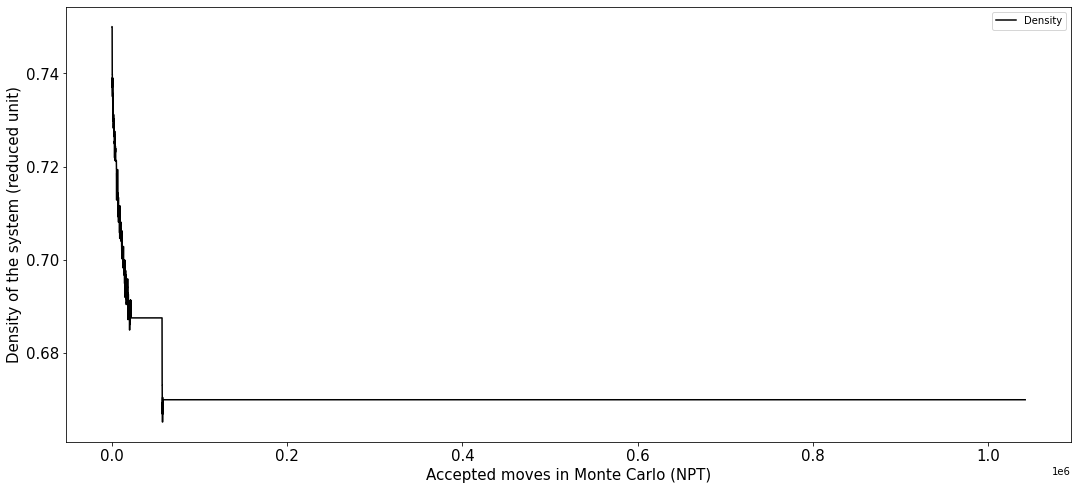

In [8]:
plt.figure(figsize=(18,8))
plt.plot(range(len(rhot)), rhot, color='black', label='Density')
plt.xlabel('Accepted moves in Monte Carlo (NPT)', fontsize=15)
plt.ylabel('Density of the system (reduced unit)',fontsize=15)
plt.xticks(fontsize=15)
plt.legend()
plt.yticks(fontsize=15)

plt.show()

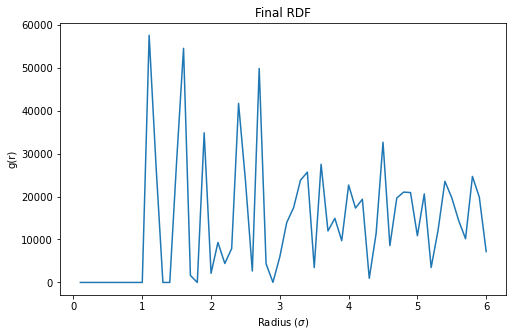

In [9]:
# Printing final average RDF in the text file
# gr = gr / rdfps
# Plotting RDF
plt.figure(figsize=(8,5))
plt.plot(Radius, gr)
plt.title('Final RDF')
plt.xlabel('Radius ($\sigma$)')
plt.ylabel('g(r)')
plt.show()

In [10]:
rv

29757